# Bidirectional trajectories of stroke and psychosis: A 16-year longitudinal population study of older adults

## Stroke risk after psychosis analysis

In [42]:
library(dplyr)
library(survival)
library(survminer)
library(forestmodel)

Load pre-processed dataframe created by Stroke_Psychosis_ELSA_Pre-processing.R

In [2]:
transformed_data_dir = "/home/main/data/StrokePsychosisELSATransformedData/"
transformed_data_filename = paste(transformed_data_dir, "waves12345.rda", sep="")

load(file = transformed_data_filename)

#### Recode and arrange data

In [3]:
strokeinpsychosis_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
strokeinpsychosis_surv$wavefirstparticipate <- as.numeric(strokeinpsychosis_surv$wavefirstparticipate)
strokeinpsychosis_surv$wavelastparticipate <- as.numeric(strokeinpsychosis_surv$wavelastparticipate)
strokeinpsychosis_surv$wavefirstreport_stroke <- as.numeric(strokeinpsychosis_surv$wavefirstreport_stroke)
strokeinpsychosis_surv$wavefirstreport_psychosis <- as.numeric(strokeinpsychosis_surv$wavefirstreport_psychosis)
strokeinpsychosis_surv$strokeever <- as.numeric(strokeinpsychosis_surv$strokeever)
strokeinpsychosis_surv$psychosisever <- as.numeric(strokeinpsychosis_surv$psychosisever)
strokeinpsychosis_surv$netwealth_q5 <- factor(strokeinpsychosis_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to categorical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "more than once a week"] <- 1
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "once a week"] <- 2
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "one to three times a month"] <- 3

# Alcohol use
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "1-4 times/week"] <- 5
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Daily/almost daily"] <- 4
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Monthly"] <- 3
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Not at all"] <- 1
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2

# Rename variables with more print appropriate names (these appear directly on the forest plot)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         `Psychosis status` = psychosisever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

# First, account for strokes reported in wave 0 e.g. wave 0.5 (0 is already used to mean no stroke). 
# Where first reported stroke is 0.5, use 0.5 as first wave, otherwise use 'wavefirstparticipate'.
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(wavefirstparticipate = case_when(wavefirstreport_stroke == 0.5 ~ 0.5,
                                          TRUE ~ wavefirstparticipate))

# Create follow-up time variables
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavelastparticipate - wavefirstreport_psychosis, #psychosis but no stroke, f-up starts from report of psychosis to last wave participated
                              psychosisever == 0 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstparticipate, #stroke but no psychosis, f-up starts from wave first participated until stroke is reported
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_stroke > 0 & wavefirstreport_stroke < wavefirstreport_psychosis ~ 0, #if first stroke happened prior to report of psychosis, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstreport_psychosis, #psychosis and stroke, f-up starts from report of psychosis until stroke is reported
                              TRUE ~ 999)) # no 999s appear so everyone has been coded as per the above

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = fuptime * 2)

Summarise follow-up time (in years)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   6.000   7.105  12.000  16.000 

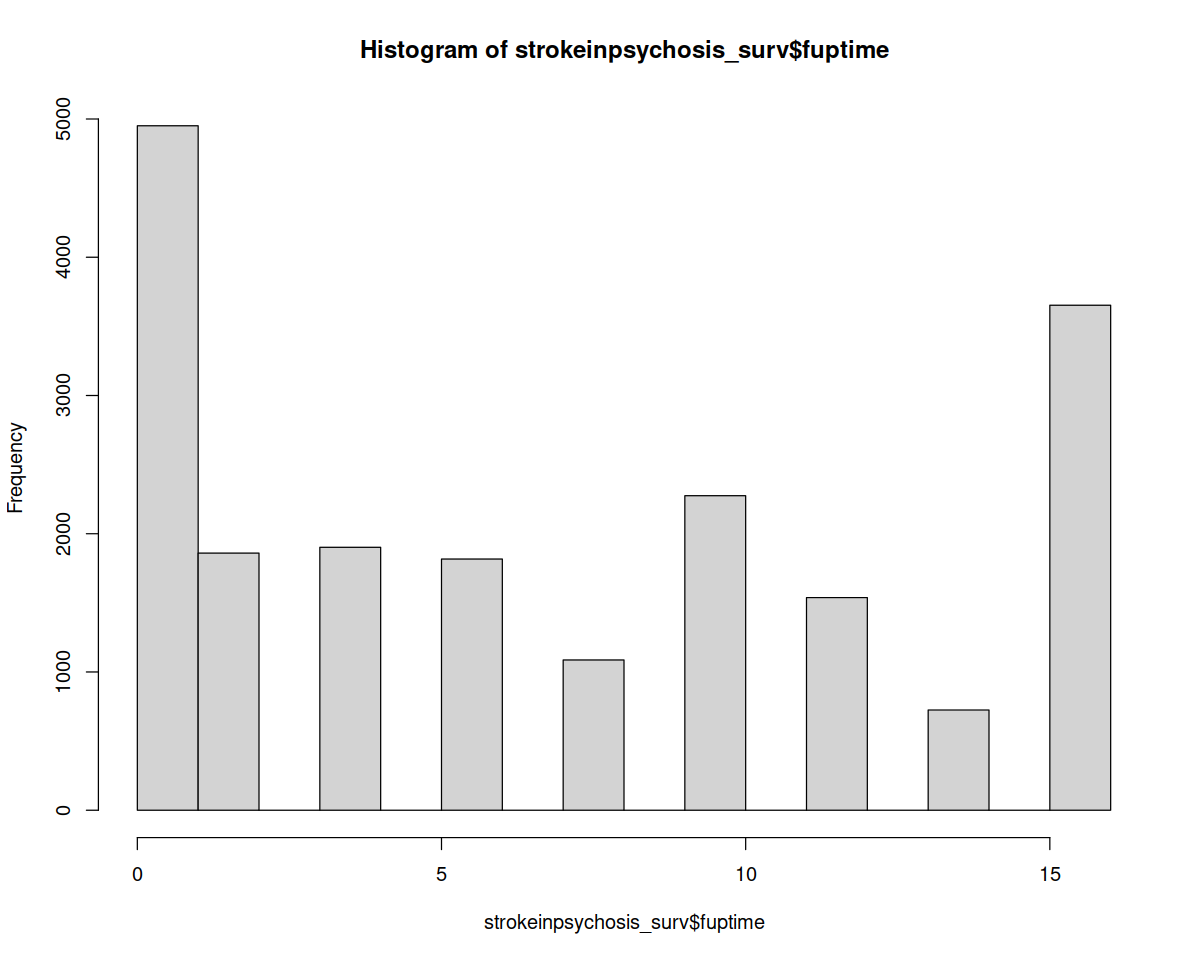

In [4]:
summary(strokeinpsychosis_surv$fuptime)

options(repr.plot.width=10, repr.plot.height=8)
hist(strokeinpsychosis_surv$fuptime)

Summarise by psychosis status

In [5]:
strokeinpsychosis_surv %>%
  group_by(psychosisever) %>%
  summarise(mean = mean(fuptime), 
            median = median(fuptime), 
            iqr_low = quantile(fuptime, probs =c(.25)), 
            iqr_upper = quantile(fuptime, probs =c(.75)))

psychosisever,mean,median,iqr_low,iqr_upper
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,7.123689,6,2,12
1,4.802469,4,0,8


#### Build survival model

In [6]:
survobj <- Surv(time = strokeinpsychosis_surv$fuptime,
                event = strokeinpsychosis_surv$strokeever)

#### Produce Kaplan-Meier estimates and curves

This creates and summarises an overall survival curve on the entire sample

In [7]:
surv_fit <- survfit(survobj ~ 1)
summary(surv_fit)
print(surv_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = survobj ~ 1)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0  19808     710    0.964 0.00132        0.962        0.967
    2  14857     139    0.955 0.00151        0.952        0.958
    4  12997     129    0.946 0.00171        0.942        0.949
    6  11095     115    0.936 0.00192        0.932        0.940
    8   9278      98    0.926 0.00215        0.922        0.930
   10   8191      88    0.916 0.00237        0.911        0.921
   12   5916      69    0.905 0.00267        0.900        0.911
   14   4378      75    0.890 0.00317        0.884        0.896
   16   3653      39    0.880 0.00348        0.874        0.887

Call: survfit(formula = survobj ~ 1)

         n     events     *rmean *se(rmean)     median    0.95LCL    0.95UCL 
  1.98e+04   1.46e+03   1.49e+01   2.89e-02         NA         NA         NA 
    * restricted mean with upper limit =  16 


#### Stratified survival

In [8]:
strokeinpsychosis_fit <- survfit(Surv(fuptime, strokeever) ~ psychosisever, data = strokeinpsychosis_surv)
summary(strokeinpsychosis_fit) # ?not possible to calculate median survival here as not enough events accrued during follow-up to reach median
print(strokeinpsychosis_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_surv)

                psychosisever=0 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0  19646     693    0.965 0.00132        0.962        0.967
    2  14749     137    0.956 0.00151        0.953        0.959
    4  12905     128    0.946 0.00171        0.943        0.950
    6  11029     114    0.937 0.00192        0.933        0.940
    8   9236      95    0.927 0.00214        0.923        0.931
   10   8159      88    0.917 0.00237        0.912        0.922
   12   5894      69    0.906 0.00267        0.901        0.911
   14   4363      75    0.891 0.00317        0.884        0.897
   16   3641      39    0.881 0.00349        0.874        0.888

                psychosisever=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0    162      17    0.895  0.0241        0.849        0.944
    2    108       2    0.878  0.0263        0.828        0.9

Call: survfit(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_surv)

                    n events *rmean *se(rmean) median 0.95LCL 0.95UCL
psychosisever=0 19646   1438   14.9     0.0288     NA      NA      NA
psychosisever=1   162     24   13.4     0.5031     NA      NA      NA
    * restricted mean with upper limit =  16 


#### Compute log rank test statistic (test of whether the curves are overlapping or not)

In [9]:
survdiff(
  Surv(fuptime, strokeever) ~ psychosisever,
  data = strokeinpsychosis_surv
)

Call:
survdiff(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_surv)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
psychosisever=0 19646     1438  1452.16     0.138        21
psychosisever=1   162       24     9.84    20.359        21

 Chisq= 21  on 1 degrees of freedom, p= 4e-06 

#### Generate survival curves plot

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


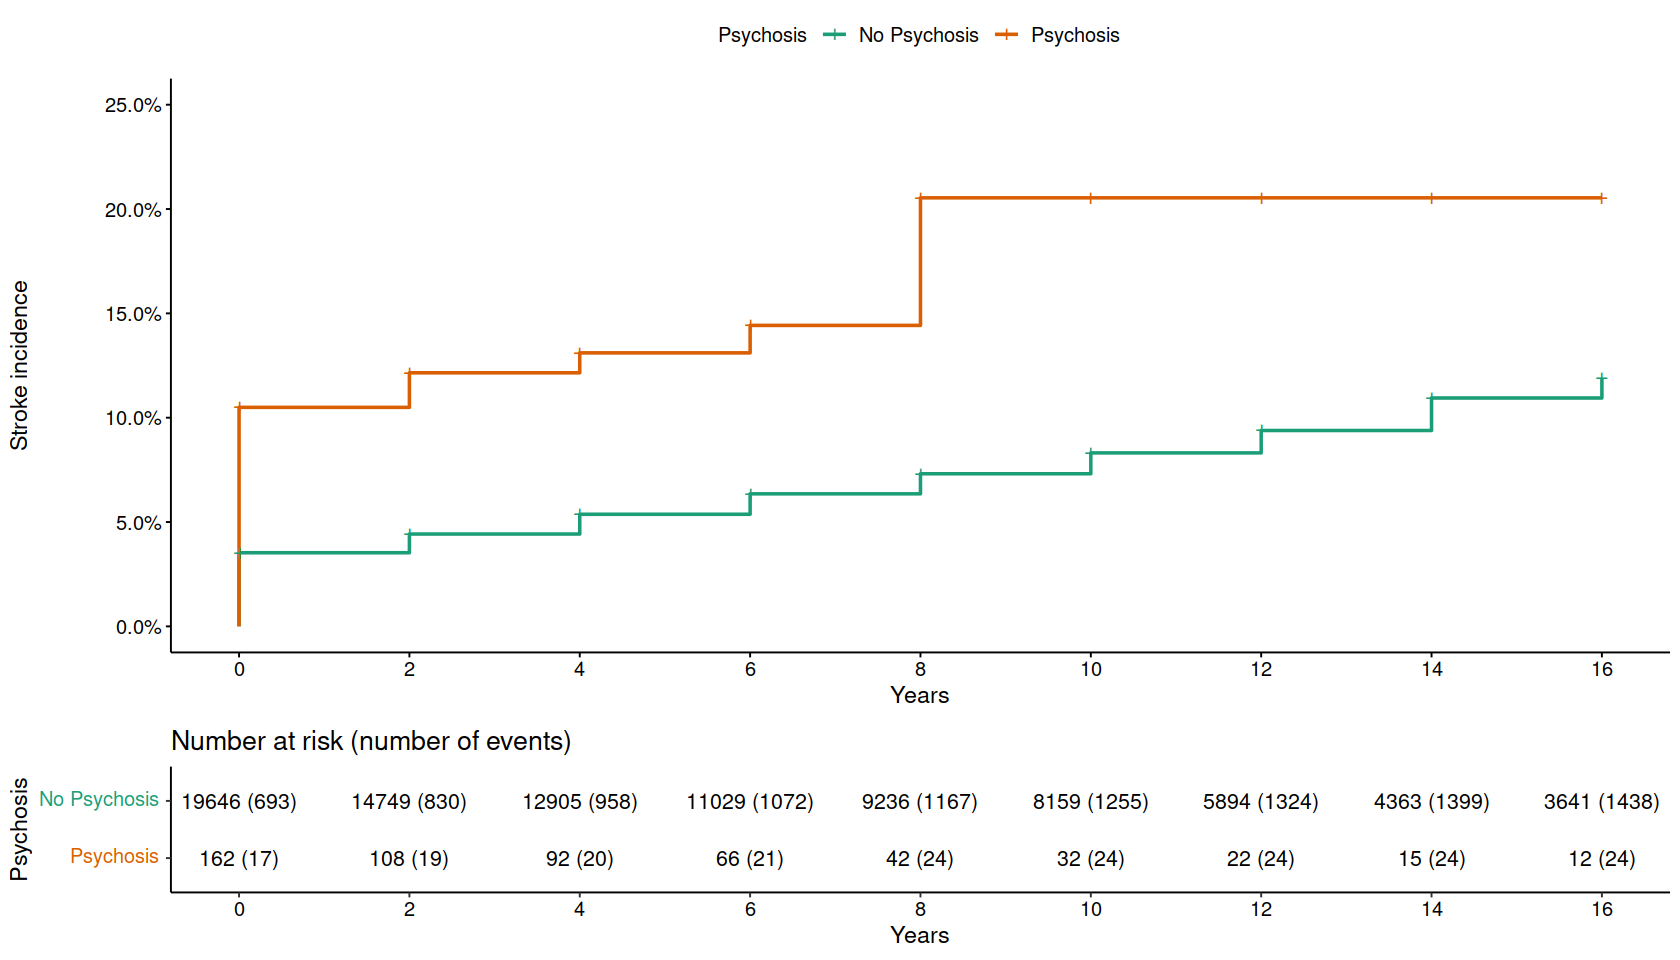

In [10]:
# Set plot size
options(repr.plot.width=14, repr.plot.height=8)

# Plot
ggsurvplot(
  strokeinpsychosis_fit,
  data = strokeinpsychosis_surv,
  fun = "event",
  conf.int = FALSE,
  surv.scale = "percent",        # present probabilities in the y axis in %
  break.time.by = 2,            # present the time axis with an increment of 1 days
  xlab = "Years",
  ylab = "Stroke incidence",
  ylim = c(0, .25),
  pval = T,                      # print p-value of Log-rank test 
  pval.coord = c(40,.91),        # print p-value at these plot coordinates
  risk.table = "nrisk_cumevents",                # print the risk table at bottom. abs_pct = absolute numbers and percentages. Can also use "absolute" or "percentage" alone.
  legend.title = "Psychosis",       # legend characteristics
  legend.labs = c("No Psychosis","Psychosis"),
  font.legend = 12, 
  palette = "Dark2",             # specify color palette 
  surv.median.line = "hv",       # draw horizontal and vertical lines to the median survivals
)

### Cox proportional hazards regression models

#### Unadjusted model

In [11]:
strokeinpsychosis_cox <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_surv
)

summary(strokeinpsychosis_cox)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_surv)

  n= 19808, number of events= 1462 

                coef exp(coef) se(coef)     z Pr(>|z|)    
psychosisever 0.9244    2.5203   0.2059 4.489 7.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever      2.52     0.3968     1.683     3.773

Concordance= 0.506  (se = 0.002 )
Likelihood ratio test= 15.26  on 1 df,   p=9e-05
Wald test            = 20.15  on 1 df,   p=7e-06
Score (logrank) test = 21.62  on 1 df,   p=3e-06


Resized limits to included dashed line in forest panel

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


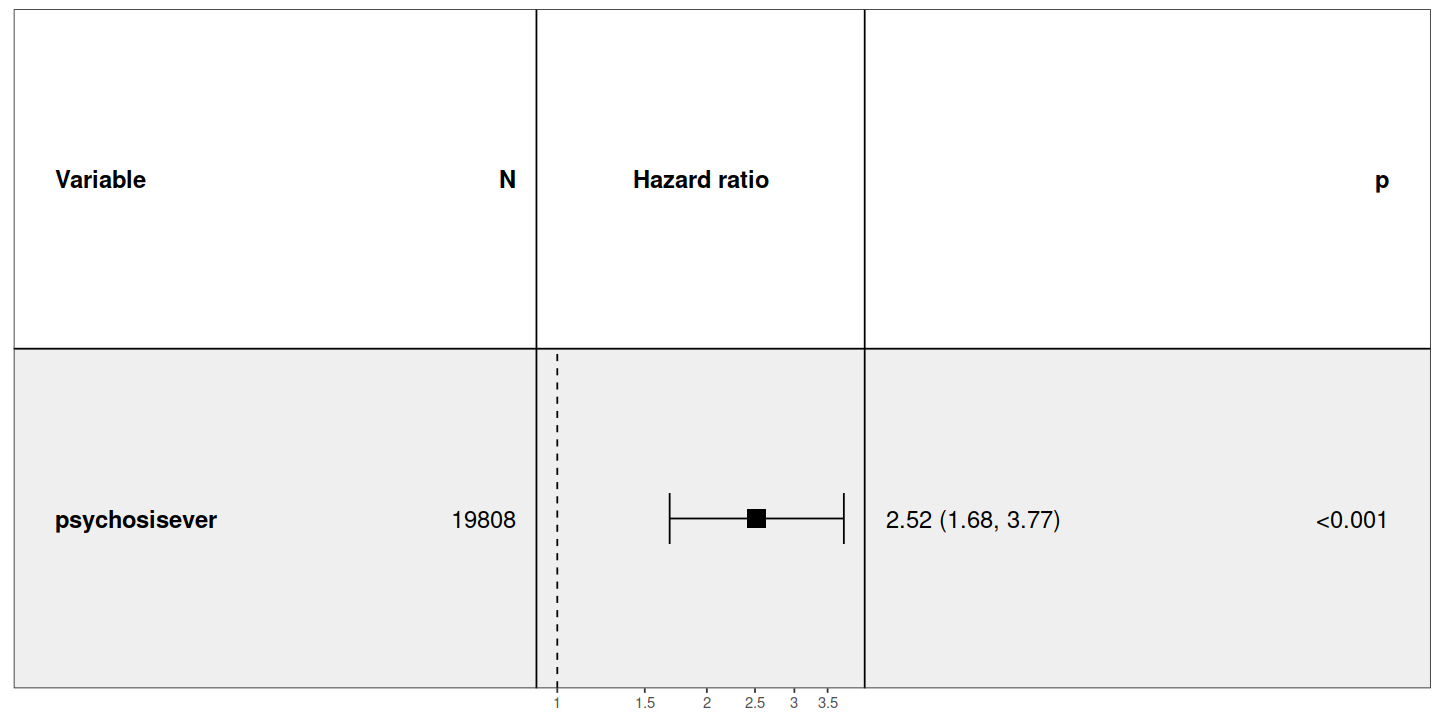

In [12]:
# Set plot size
options(repr.plot.width=12, repr.plot.height=6)

forest_model(strokeinpsychosis_cox)

#### Adjusted model 1 (with demographic covariates)

In [13]:
strokeinpsychosis_coxadj <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_surv
)

summary(strokeinpsychosis_coxadj)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_surv)

  n= 16434, number of events= 1359 
   (3374 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq  DF    p       
`Psychosis status`       1.11209 0.229059 0.216519  23.57   1.0  1.2e-06
`Age at Wave 1`          0.06677 0.002577 0.002495 671.16   1.0 5.6e-148
SexFemale               -0.30963 0.056683 0.054731  29.84   1.0  4.7e-08
`Ethnic group`Non-White  0.19095 0.162885 0.157054   1.37   1.0  2.4e-01
`Ethnic group`Unknown    0.42182 0.120515 0.116342  12.25   1.0  4.7e-04
`Wealth quintile`4       0.10724 0.098868 0.096248   1.18   1.0  2.8e-01
`Wealth quintile`3       0.33659 0.094815 0.092016  12.60   1.0  3.9e-04
`Wealth quintile`2       0.49459 0.092648 0.089747  28.50   1.0  9.4e-08
`Wealth quintile`1       0.72134 0.091526 0.088703  62

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


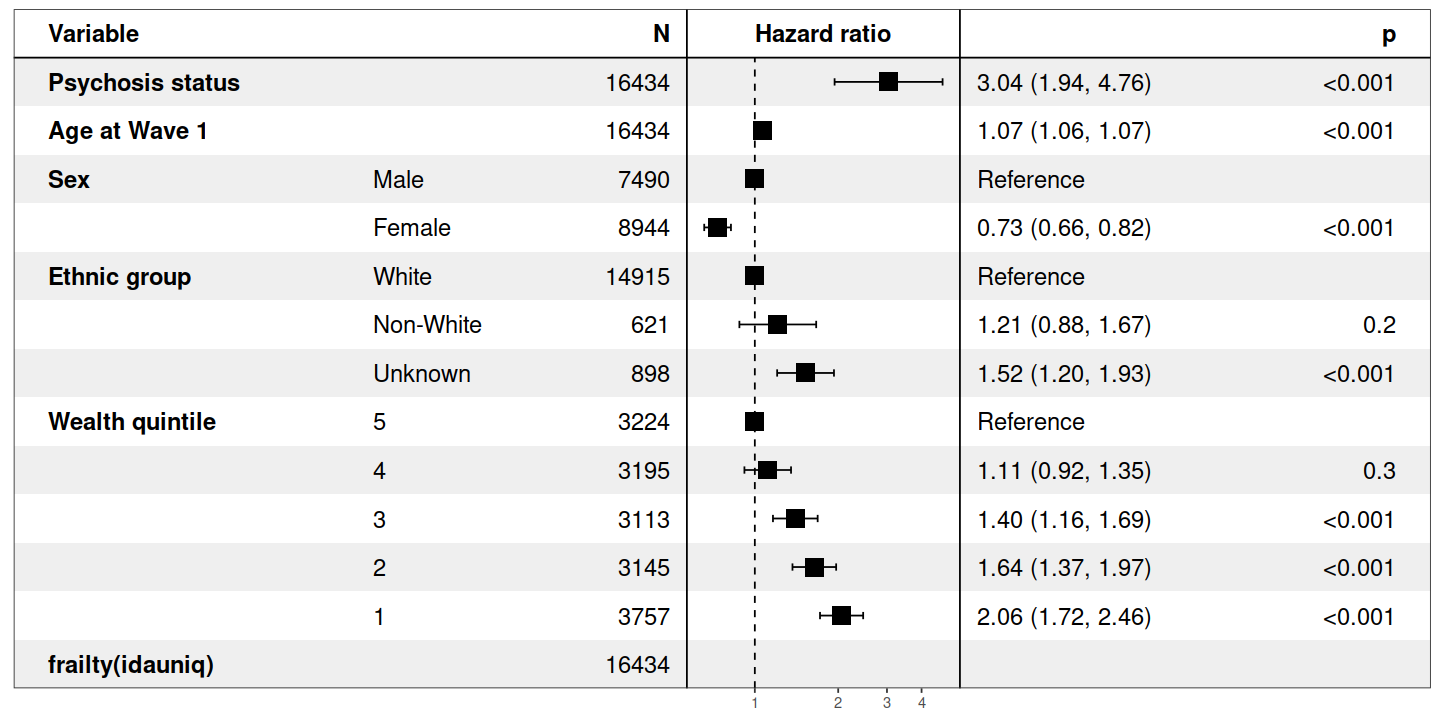

In [14]:
forest_model(strokeinpsychosis_coxadj)

#### Adjusted model 2 (with demographic and health behaviour covariates)

In [15]:
strokeinpsychosis_coxadj2 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_surv
)

summary(strokeinpsychosis_coxadj2)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_surv)

  n= 14895, number of events= 1271 
   (4913 observations deleted due to missingness)

                        coef      se(coef) se2      Chisq   DF   p       
`Psychosis status`       1.015112 0.29262  0.251640   12.03    1  5.2e-04
`Age at Wave 1`          0.072116 0.00319  0.002898  510.91    1 4.0e-113
SexFemale               -0.417579 0.06661  0.059275   39.30    1  3.6e-10
`Ethnic group`Non-White -0.001299 0.20491  0.181898    0.00    1  9.9e-01
`Ethnic group`Unknown    0.382063 0.13958  0.124805    7.49    1  6.2e-03
`Wealth quintile`4       0.039538 0.10947  0.099342    0.13    1  7.2e-01
`Wealth quintile`3       0.276420 0.10618  0.095393    6.78    1  9.2e-03
`Wealth quintile`2       0.357679 0.10614  0.0949

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


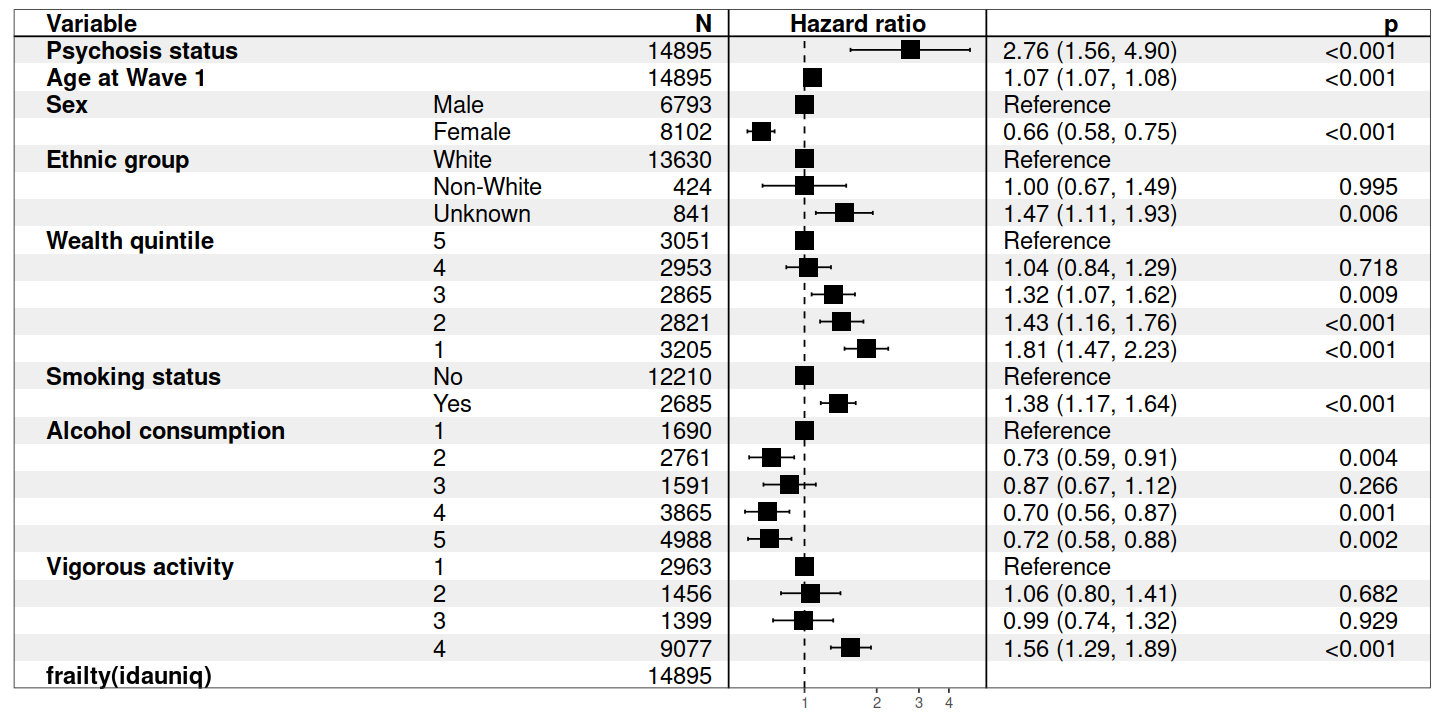

In [16]:
forest_model(strokeinpsychosis_coxadj2)

### Sex-stratified analysis

Select females only

In [17]:
strokeinpsychosis_female <- strokeinpsychosis_surv %>%
  filter(Sex == "Female")

#### Females unadjusted analysis

In [18]:
strokeinpsychosis_coxfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_female
)

summary(strokeinpsychosis_coxfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_female)

  n= 10797, number of events= 725 

                coef exp(coef) se(coef)     z Pr(>|z|)    
psychosisever 1.2004    3.3214   0.2456 4.888 1.02e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever     3.321     0.3011     2.052     5.375

Concordance= 0.51  (se = 0.003 )
Likelihood ratio test= 16.84  on 1 df,   p=4e-05
Wald test            = 23.89  on 1 df,   p=1e-06
Score (logrank) test = 26.9  on 1 df,   p=2e-07


#### Females adjusted model 1 (with demographic covariates)

In [19]:
strokeinpsychosis_coxadjfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_female
)

summary(strokeinpsychosis_coxadjfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_female)

  n= 8944, number of events= 682 
   (1853 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq  DF    p      
`Psychosis status`       1.30600 0.262420 0.254057  24.77   1.0 6.5e-07
`Age at Wave 1`          0.06508 0.003502 0.003453 345.33   1.0 4.4e-77
SexFemale                        0.000000 0.000000          1.0        
`Ethnic group`Non-White  0.26043 0.239317 0.235561   1.18   1.0 2.8e-01
`Ethnic group`Unknown    0.58639 0.163174 0.160503  12.91   1.0 3.3e-04
`Wealth quintile`4      -0.04957 0.145581 0.144045   0.12   1.0 7.3e-01
`Wealth quintile`3       0.32859 0.133530 0.131861   6.06   1.0 1.4e-02
`Wealth quintile`2       0.42092 0.129973 0.128241  10.49   1.0 1.2e-03
`Wealth quintile`1       0.57695 0.130107 0.128437  19.66   1.0

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [20]:
strokeinpsychosis_coxadj2female <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_female
)

summary(strokeinpsychosis_coxadj2female)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_female)

  n= 8102, number of events= 637 
   (2695 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq   DF   p      
`Psychosis status`       1.23963 0.359805 0.30273   11.87    1 5.7e-04
`Age at Wave 1`          0.07142 0.004485 0.00408  253.58    1 4.3e-57
SexFemale                        0.000000 0.00000            1        
`Ethnic group`Non-White  0.27478 0.298677 0.26349    0.85    1 3.6e-01
`Ethnic group`Unknown    0.56049 0.196468 0.17487    8.14    1 4.3e-03
`Wealth quintile`4      -0.13389 0.163318 0.14887    0.67    1 4.1e-01
`Wealth quintile`3       0.26335 0.152992 0.13749    2.96    1 8.5e-02
`Wealth quintile`2       0.31623 0.151759 0.13576    4.34    1 3.7e-02
`W

#### Males only

In [21]:
strokeinpsychosis_male <- strokeinpsychosis_surv %>%
  filter(Sex == "Male")

#### Males unadjusted analysis

In [22]:
strokeinpsychosis_coxmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_male
)

summary(strokeinpsychosis_coxmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_male)

  n= 9011, number of events= 737 

                coef exp(coef) se(coef)     z Pr(>|z|)
psychosisever 0.4906    1.6332   0.3799 1.291    0.197

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever     1.633     0.6123    0.7756     3.439

Concordance= 0.502  (se = 0.002 )
Likelihood ratio test= 1.43  on 1 df,   p=0.2
Wald test            = 1.67  on 1 df,   p=0.2
Score (logrank) test = 1.7  on 1 df,   p=0.2


#### Males adjusted model 1 (with demographic covariates)

In [23]:
strokeinpsychosis_coxadjmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_male
)

summary(strokeinpsychosis_coxadjmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_male)

  n= 7490, number of events= 677 
   (1521 observations deleted due to missingness)

                        coef    se(coef) se2     Chisq  DF    p      
`Psychosis status`      0.69764 0.445797 0.41438   2.45   1.0 1.2e-01
`Age at Wave 1`         0.06994 0.003899 0.00366 321.80   1.0 5.9e-72
SexFemale                       0.000000 0.00000          1.0        
`Ethnic group`Non-White 0.12565 0.227403 0.21159   0.31   1.0 5.8e-01
`Ethnic group`Unknown   0.24670 0.181199 0.16968   1.85   1.0 1.7e-01
`Wealth quintile`4      0.24583 0.137356 0.12958   3.20   1.0 7.3e-02
`Wealth quintile`3      0.33334 0.137419 0.12926   5.88   1.0 1.5e-02
`Wealth quintile`2      0.56464 0.135169 0.12661  17.45   1.0 3.0e-05
`Wealth quintile`1      0.89372 0.131642 0.12328  46.09   1.0 1.1e-11
frailty(idaun

#### Males adjusted model 2 (with demographic and health behaviour covariates)

In [24]:
strokeinpsychosis_coxadj2male <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_male
)

summary(strokeinpsychosis_coxadj2male)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_male)

  n= 6793, number of events= 634 
   (2218 observations deleted due to missingness)

                        coef    se(coef) se2      Chisq  DF    p      
`Psychosis status`       0.5966 0.513241 0.457938   1.35   1.0 2.5e-01
`Age at Wave 1`          0.0727 0.004551 0.004139 255.24   1.0 1.9e-57
SexFemale                       0.000000 0.000000          1.0        
`Ethnic group`Non-White -0.2087 0.280152 0.252037   0.55   1.0 4.6e-01
`Ethnic group`Unknown    0.2103 0.197796 0.178218   1.13   1.0 2.9e-01
`Wealth quintile`4       0.1735 0.146951 0.133359   1.39   1.0 2.4e-01
`Wealth quintile`3       0.2649 0.147454 0.133089   3.23   1.0 7.2e-02
`Wealth quintile`2       0.3783 0.149154 0.134017   6.43   1.0 1.1e-02
`Wea

### Age stratified analysis

#### Age <60

In [25]:
strokeinpsychosis_ageless60 <- strokeinpsychosis_surv %>%
  filter(age_cat == "<60")

#### Age <60 unadjusted analysis

In [26]:
strokeinpsychosis_coxageless60 <- survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_ageless60
)

summary(strokeinpsychosis_coxageless60)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_ageless60)

  n= 11465, number of events= 369 

                coef exp(coef) se(coef)     z Pr(>|z|)    
psychosisever 1.1303    3.0967   0.3378 3.346 0.000819 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever     3.097     0.3229     1.597     6.004

Concordance= 0.51  (se = 0.005 )
Likelihood ratio test= 8.05  on 1 df,   p=0.005
Wald test            = 11.2  on 1 df,   p=8e-04
Score (logrank) test = 12.44  on 1 df,   p=4e-04


#### Age <60 adjusted model 1 (with demographic covariates)

In [27]:
strokeinpsychosis_coxageless60adj1 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_ageless60
)

summary(strokeinpsychosis_coxageless60adj1)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_ageless60)

  n= 8504, number of events= 310 
   (2961 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF  p      
`Psychosis status`       0.94524 0.41323  0.36464   5.23   1 2.2e-02
`Age at Wave 1`          0.03432 0.01199  0.01146   8.19   1 4.2e-03
SexFemale               -0.39805 0.12261  0.11456  10.54   1 1.2e-03
`Ethnic group`Non-White  0.27120 0.26820  0.24735   1.02   1 3.1e-01
`Ethnic group`Unknown    0.82420 0.36954  0.35002   4.97   1 2.6e-02
`Wealth quintile`4      -0.09006 0.22025  0.20931   0.17   1 6.8e-01
`Wealth quintile`3       0.06802 0.22373  0.21227   0.09   1 7.6e-01
`Wealth quintile`2       0.41176 0.21619  0.20367   3.63   1 5.7e-02
`Wealth quintile`1       0.90374 0.18310  0.17156  24.36   1 8.0e-07
frailty(idauniq)  

#### Age <60 adjusted model 2 (with demographic and health behaviour covariates)

In [28]:
strokeinpsychosis_coxageless60adj2 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_ageless60
)

summary(strokeinpsychosis_coxageless60adj2)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_ageless60)

  n= 7213, number of events= 274 
   (4252 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF   p      
`Psychosis status`       0.39806 0.54465  0.46269   0.53    1 4.6e-01
`Age at Wave 1`          0.04085 0.01494  0.01377   7.48    1 6.2e-03
SexFemale               -0.60511 0.14321  0.12790  17.85    1 2.4e-05
`Ethnic group`Non-White  0.01207 0.35375  0.30928   0.00    1 9.7e-01
`Ethnic group`Unknown    0.92048 0.39313  0.35679   5.48    1 1.9e-02
`Wealth quintile`4      -0.20505 0.23696  0.21537   0.75    1 3.9e-01
`Wealth quintile`3      -0.03373 0.24081  0.21795   0.02    1 8.9e-01
`Wealth quintile`2      -0.07150 0.24983  0.22611   0.08    1 7.7e-01
`Wealth 

#### Age 60-69

In [29]:
strokeinpsychosis_age60to69 <- strokeinpsychosis_surv %>%
  filter(age_cat == "60-69")

#### Age 60-69 unadjusted analysis

In [30]:
strokeinpsychosis_coxage60to69 <- survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_age60to69
)

summary(strokeinpsychosis_coxage60to69)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_age60to69)

  n= 4280, number of events= 420 

                coef exp(coef) se(coef)     z Pr(>|z|)  
psychosisever 1.0973    2.9961   0.4501 2.438   0.0148 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever     2.996     0.3338      1.24     7.239

Concordance= 0.505  (se = 0.003 )
Likelihood ratio test= 4.28  on 1 df,   p=0.04
Wald test            = 5.94  on 1 df,   p=0.01
Score (logrank) test = 6.56  on 1 df,   p=0.01


#### Age 60-69 adjusted model 1 (with demographic covariates)

In [31]:
strokeinpsychosis_coxage60to69adj1 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_age60to69
)

summary(strokeinpsychosis_coxage60to69adj1)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_age60to69)

  n= 4042, number of events= 399 
   (238 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq   DF   p      
`Psychosis status`       1.36907 0.69410  0.53945    3.89    1 4.9e-02
`Age at Wave 1`          0.09832 0.02178  0.01843   20.37    1 6.4e-06
SexFemale               -0.38589 0.12247  0.10307    9.93    1 1.6e-03
`Ethnic group`Non-White -0.16106 0.36662  0.30328    0.19    1 6.6e-01
`Ethnic group`Unknown    0.54798 0.30085  0.26586    3.32    1 6.9e-02
`Wealth quintile`4       0.32553 0.19584  0.17015    2.76    1 9.6e-02
`Wealth quintile`3       0.59248 0.19327  0.16647    9.40    1 2.2e-03
`Wealth quintile`2       0.97943 0.19576  0.16658   25.03    1 5.6e-07
`Wealth quintile`1       1.11907 0.19405  0.16451   33.26    1 8.1e-09

#### Age 60-69 adjusted model 2 (with demographic and health behaviour covariates)

In [32]:
strokeinpsychosis_coxage60to69adj2 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_age60to69
)

summary(strokeinpsychosis_coxage60to69adj2)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_age60to69)

  n= 3887, number of events= 376 
   (393 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq   DF   p      
`Psychosis status`       1.55114 0.83047  0.57136    3.49    1 6.2e-02
`Age at Wave 1`          0.10546 0.02636  0.02011   16.01    1 6.3e-05
SexFemale               -0.50410 0.15274  0.11586   10.89    1 9.7e-04
`Ethnic group`Non-White -0.58145 0.48652  0.36930    1.43    1 2.3e-01
`Ethnic group`Unknown    0.42823 0.35807  0.29075    1.43    1 2.3e-01
`Wealth quintile`4       0.21436 0.23246  0.18196    0.85    1 3.6e-01
`Wealth quintile`3       0.60411 0.23101  0.17811    6.84    1 8.9e-03
`Wealth quintile`2       1.00470 0.23879  0.18230   17.70    1 2.6e-05


#### Age 70+

In [33]:
strokeinpsychosis_age70plus <- strokeinpsychosis_surv %>%
  filter(age_cat == "70+")

#### Age 70+ unadjusted analysis

In [34]:
strokeinpsychosis_coxage70plus <- survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever, 
  data = strokeinpsychosis_age70plus
)

summary(strokeinpsychosis_coxage70plus)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever, 
    data = strokeinpsychosis_age70plus)

  n= 4061, number of events= 673 

                coef exp(coef) se(coef)     z Pr(>|z|)    
psychosisever 1.2548    3.5072   0.3192 3.931 8.44e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
psychosisever     3.507     0.2851     1.876     6.556

Concordance= 0.506  (se = 0.003 )
Likelihood ratio test= 10.7  on 1 df,   p=0.001
Wald test            = 15.46  on 1 df,   p=8e-05
Score (logrank) test = 17.59  on 1 df,   p=3e-05


#### Age 70+ adjusted model 1 (with demographic covariates)

In [35]:
strokeinpsychosis_coxage70plusadj1 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq),
  data = strokeinpsychosis_age70plus
)

summary(strokeinpsychosis_coxage70plusadj1)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = strokeinpsychosis_age70plus)

  n= 3888, number of events= 650 
   (173 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq DF   p      
`Psychosis status`       1.32125 0.319590 0.319587 17.09 1.00 3.6e-05
`Age at Wave 1`          0.04550 0.007526 0.007526 36.55 1.00 1.5e-09
SexFemale               -0.21983 0.079931 0.079930  7.56 1.00 6.0e-03
`Ethnic group`Non-White  0.31177 0.283313 0.283311  1.21 1.00 2.7e-01
`Ethnic group`Unknown    0.42039 0.140338 0.140338  8.97 1.00 2.7e-03
`Wealth quintile`4       0.06533 0.141851 0.141850  0.21 1.00 6.5e-01
`Wealth quintile`3       0.28067 0.131905 0.131904  4.53 1.00 3.3e-02
`Wealth quintile`2       0.32560 0.127932 0.127932  6.48 1.00 1.1e-02
`Wealth quintile`1       0.40900 0.140858 0.140858  8.43 1.00 3.7e-03
frailty(i

#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [36]:
strokeinpsychosis_coxage70plusadj2 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ `Psychosis status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = strokeinpsychosis_age70plus
)

summary(strokeinpsychosis_coxage70plusadj2)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ `Psychosis status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = strokeinpsychosis_age70plus)

  n= 3795, number of events= 621 
   (266 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq  DF    p      
`Psychosis status`       1.37587 0.428156 0.365726  10.33   1.0 1.3e-03
`Age at Wave 1`          0.04862 0.008689 0.007985  31.31   1.0 2.2e-08
SexFemale               -0.28885 0.092985 0.085130   9.65   1.0 1.9e-03
`Ethnic group`Non-White  0.24849 0.332284 0.297562   0.56   1.0 4.5e-01
`Ethnic group`Unknown    0.37981 0.159667 0.149759   5.66   1.0 1.7e-02
`Wealth quintile`4       0.06977 0.156405 0.144523   0.20   1.0 6.6e-01
`Wealth quintile`3       0.28214 0.147604 0.135647   3.65   1.0 5.6e-02
`Wealth quintile`2       0.29664 0.144444 0.132946   4.22   1.0

## Analysis platform details and software versions

In [37]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [38]:
packageVersion("dplyr")

[1] ‘1.0.9’

In [39]:
packageVersion("survival")

[1] ‘3.2.7’

In [40]:
packageVersion("survminer")

[1] ‘0.4.9’

In [41]:
packageVersion("forestmodel")

[1] ‘0.6.2’